# **Proyecto | Deep Learning | GANs**

**Ruta:** GANs (Generación de imágenes)  
**Dataset:** CIFAR-10 (32×32×3)  
**Variantes:** A) DCGAN, B) WGAN-GP, C) LSGAN  
**Métricas:** FID, KID, IS + pérdidas G/D  


### **1) Setup**

Instalar las dependencias de requirements.txt

In [1]:
import os, math, random, time, json
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange
from pathlib import Path

In [2]:
import torch

def get_device():
    if torch.cuda.is_available():
        print("CUDA disponible (NVIDIA)")
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        print("MPS disponible (Apple Silicon)")
        return torch.device("mps")
    print("GPU no disponible: usando CPU")
    return torch.device("cpu")

DEVICE = get_device()


MPS disponible (Apple Silicon)


In [3]:

SEED = 1337
random.seed(SEED); torch.manual_seed(SEED); 
if DEVICE=='cuda': torch.cuda.manual_seed_all(SEED)

RESULTS_DIR = './results'
os.makedirs(RESULTS_DIR, exist_ok=True)
EPOCHS = 10    
BATCH_SIZE = 128
Z_DIM = 128
IMG_SIZE = 32
NC = 3           
LR = 2e-4
N_SAMPLES_GRID = 64 
FID_BATCH = 64

### **2) Carga de dataset (CIFAR-10)**

In [7]:
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(testset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

len(trainset), len(testset)

(50000, 10000)

/Users/nayeli/Library/Python/3.13/lib/python/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


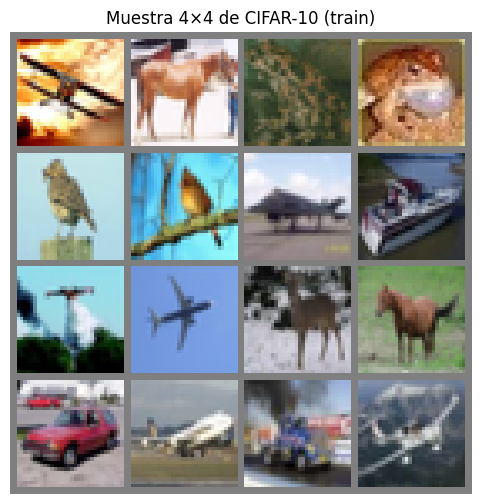

In [8]:
import torch, random
import matplotlib.pyplot as plt
import numpy as np

from torchvision.utils import make_grid

batch = next(iter(train_loader))[0][:16]   # 16 imágenes del primer batch
grid = make_grid(batch, nrow=4)

grid_np = grid.detach().cpu().numpy()
grid_np = (grid_np * 0.5 + 0.5).clip(0,1)
grid_np = np.transpose(grid_np, (1,2,0))

plt.figure(figsize=(6,6))
plt.imshow(grid_np)
plt.axis('off')
plt.title("Muestra 4×4 de CIFAR-10 (train)")
plt.show()


### **3) Modelos (DCGAN base)**

In [9]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.zeros_(m.bias.data)

class GeneratorDCGAN(nn.Module):
    def __init__(self, z_dim=Z_DIM, ngf=64, nc=NC):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf*4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*4), nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2), nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf), nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, z):
        return self.net(z)

class DiscriminatorDCGAN(nn.Module):
    def __init__(self, ndf=64, nc=NC):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False), nn.BatchNorm2d(ndf*2), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False), nn.BatchNorm2d(ndf*4), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*4, 1, 4, 1, 0, bias=False)
        )
    def forward(self, x):
        return self.net(x).view(-1)

def sample_noise(n, z_dim=Z_DIM, device=DEVICE):
    return torch.randn(n, z_dim, 1, 1, device=device)


### **4) Entrenamiento — DCGAN, WGAN-GP, LSGAN**

In [10]:
def save_grid(tensor, path, nrow=8):
    grid = make_grid((tensor*0.5+0.5).clamp(0,1), nrow=nrow)
    save_image(grid, path)

def train_dcgan(epochs=EPOCHS):
    G = GeneratorDCGAN().to(DEVICE).apply(weights_init)
    D = DiscriminatorDCGAN().to(DEVICE).apply(weights_init)
    optG = torch.optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.999))
    optD = torch.optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.999))
    criterion = nn.BCEWithLogitsLoss()
    fixed_z = sample_noise(N_SAMPLES_GRID)
    G_losses, D_losses = [], []
    for epoch in range(1, epochs+1):
        pbar = tqdm(train_loader, desc=f'DCGAN Epoch {epoch}/{epochs}')
        for real,_ in pbar:
            real = real.to(DEVICE)
            bs = real.size(0)
            # === Train D ===
            z = sample_noise(bs)
            fake = G(z).detach()
            logits_real = D(real)
            logits_fake = D(fake)
            lossD = criterion(logits_real, torch.ones_like(logits_real)) + \
                    criterion(logits_fake, torch.zeros_like(logits_fake))
            optD.zero_grad(); lossD.backward(); optD.step()
            # === Train G ===
            z = sample_noise(bs)
            fake = G(z)
            logits_fake = D(fake)
            lossG = criterion(logits_fake, torch.ones_like(logits_fake))
            optG.zero_grad(); lossG.backward(); optG.step()
            G_losses.append(lossG.item()); D_losses.append(lossD.item())
        with torch.no_grad():
            samples = G(fixed_z).cpu()
            save_grid(samples, f'{RESULTS_DIR}/dcgan_epoch_{epoch:03d}.png')
    torch.save(G.state_dict(), f'{RESULTS_DIR}/G_dcgan.pt')
    torch.save(D.state_dict(), f'{RESULTS_DIR}/D_dcgan.pt')
    return G, D, G_losses, D_losses

def gradient_penalty(D, real, fake):
    bs = real.size(0)
    eps = torch.rand(bs, 1, 1, 1, device=DEVICE)
    inter = eps*real + (1-eps)*fake
    inter.requires_grad_(True)
    d_inter = D(inter)
    grads = torch.autograd.grad(d_inter, inter, grad_outputs=torch.ones_like(d_inter),
                                create_graph=True, retain_graph=True, only_inputs=True)[0]
    grads = grads.view(bs, -1)
    gp = ((grads.norm(2, dim=1) - 1)**2).mean()
    return gp

def train_wgan_gp(epochs=EPOCHS, lambda_gp=10.0, n_critic=5):
    G = GeneratorDCGAN().to(DEVICE).apply(weights_init)
    D = DiscriminatorDCGAN().to(DEVICE).apply(weights_init)
    optG = torch.optim.Adam(G.parameters(), lr=LR, betas=(0.0, 0.9))
    optD = torch.optim.Adam(D.parameters(), lr=LR, betas=(0.0, 0.9))
    fixed_z = sample_noise(N_SAMPLES_GRID)
    G_losses, D_losses = [], []
    for epoch in range(1, epochs+1):
        pbar = tqdm(train_loader, desc=f'WGAN-GP Epoch {epoch}/{epochs}')
        i = 0
        for real,_ in pbar:
            real = real.to(DEVICE); bs = real.size(0)
            # === Train D (n_critic) ===
            for _ in range(n_critic):
                z = sample_noise(bs)
                fake = G(z).detach()
                lossD = -(D(real).mean() - D(fake).mean())
                gp = gradient_penalty(D, real, fake)
                lossD_total = lossD + lambda_gp*gp
                optD.zero_grad(); lossD_total.backward(); optD.step()
                D_losses.append(lossD.item())
                i += 1
                if i >= len(train_loader):
                    break
            # === Train G ===
            z = sample_noise(bs)
            fake = G(z)
            lossG = -D(fake).mean()
            optG.zero_grad(); lossG.backward(); optG.step()
            G_losses.append(lossG.item())
        with torch.no_grad():
            samples = G(fixed_z).cpu()
            save_grid(samples, f'{RESULTS_DIR}/wgan_gp_epoch_{epoch:03d}.png')
    torch.save(G.state_dict(), f'{RESULTS_DIR}/G_wgan_gp.pt')
    torch.save(D.state_dict(), f'{RESULTS_DIR}/D_wgan_gp.pt')
    return G, D, G_losses, D_losses

def train_lsgan(epochs=EPOCHS):
    G = GeneratorDCGAN().to(DEVICE).apply(weights_init)
    D = DiscriminatorDCGAN().to(DEVICE).apply(weights_init)
    optG = torch.optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.999))
    optD = torch.optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.999))
    fixed_z = sample_noise(N_SAMPLES_GRID)
    G_losses, D_losses = [], []
    for epoch in range(1, epochs+1):
        pbar = tqdm(train_loader, desc=f'LSGAN Epoch {epoch}/{epochs}')
        for real,_ in pbar:
            real = real.to(DEVICE); bs = real.size(0)
            # === Train D (least squares) ===
            z = sample_noise(bs); fake = G(z).detach()
            lossD = 0.5 * ((D(real) - 1)**2).mean() + 0.5 * ((D(fake) - 0)**2).mean()
            optD.zero_grad(); lossD.backward(); optD.step()
            # === Train G ===
            z = sample_noise(bs); fake = G(z)
            lossG = 0.5 * ((D(fake) - 1)**2).mean()
            optG.zero_grad(); lossG.backward(); optG.step()
            G_losses.append(lossG.item()); D_losses.append(lossD.item())
        with torch.no_grad():
            samples = G(fixed_z).cpu()
            save_grid(samples, f'{RESULTS_DIR}/lsgan_epoch_{epoch:03d}.png')
    torch.save(G.state_dict(), f'{RESULTS_DIR}/G_lsgan.pt')
    torch.save(D.state_dict(), f'{RESULTS_DIR}/D_lsgan.pt')
    return G, D, G_losses, D_losses


### **5) Evaluación: FID, KID, IS y curvas de pérdidas**

In [11]:
from torch_fidelity import calculate_metrics

def export_real_subset(real_loader, out_dir, max_imgs=5000):
    os.makedirs(out_dir, exist_ok=True)
    n = 0
    for x,_ in real_loader:
        for img in x:
            save_image((img*0.5+0.5).clamp(0,1), os.path.join(out_dir, f'real_{n:06d}.png'))
            n += 1
            if n >= max_imgs: break
        if n >= max_imgs: break

def save_generated_samples(G, count, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    saved = 0
    G.eval()
    with torch.no_grad():
        while saved < count:
            bs = min(256, count - saved)
            z = sample_noise(bs)
            imgs = G(z).cpu()
            for img in imgs:
                save_image((img*0.5+0.5).clamp(0,1), os.path.join(out_dir, f'gen_{saved:06d}.png'))
                saved += 1
                if saved >= count: break

def compute_fid_kid_is(gen_dir, real_dir):
    metrics = calculate_metrics(input1=str(gen_dir), input2=str(real_dir),
                                cuda=(DEVICE=='cuda'), isc=True, fid=True, kid=True, verbose=False)
    return {
        'FID': float(metrics.get('frechet_inception_distance', float('nan'))),
        'KID_mean': float(metrics.get('kernel_inception_distance_mean', float('nan'))),
        'IS_mean': float(metrics.get('inception_score_mean', float('nan')))
    }

def plot_losses(G_losses, D_losses, title, out_path):
    plt.figure()
    plt.plot(G_losses, label='G loss')
    plt.plot(D_losses, label='D loss')
    plt.title(title); plt.xlabel('iter'); plt.ylabel('loss'); plt.legend();
    plt.savefig(out_path); plt.close()


### **6) Ejecución**

In [12]:
DO_DCGAN = True
DO_WGANGP = True
DO_LSGAN = True

export_real_subset(test_loader, os.path.join(RESULTS_DIR, 'real_eval'), max_imgs=5000)

results = []

/Users/nayeli/Library/Python/3.13/lib/python/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
if DO_DCGAN:
    G, D, G_losses, D_losses = train_dcgan()
    plot_losses(G_losses, D_losses, 'DCGAN losses', f'{RESULTS_DIR}/loss_dcgan.png')
    # Generar 10k imágenes para métricas (ajusta si no tienes tiempo)
    gen_dir = os.path.join(RESULTS_DIR, 'gen_dcgan_eval')
    save_generated_samples(G, 10000, gen_dir)
    metrics = compute_fid_kid_is(gen_dir, os.path.join(RESULTS_DIR, 'real_eval'))
    results.append({'Config':'A-DCGAN','Cambio':'Baseline','FID':metrics['FID'],'KID':metrics['KID_mean'],'IS':metrics['IS_mean']})

In [13]:
real_dir = os.path.join(RESULTS_DIR, 'real_eval')
gen_dir  = os.path.join(RESULTS_DIR, 'gen_dcgan_eval')

In [23]:
metrics = compute_fid_kid_is(gen_dir, real_dir)
print(metrics)
results.append({
    'Config':'A-DCGAN', 'Cambio':'Baseline',
    'FID': metrics['FID'], 'KID': metrics['KID_mean'], 'IS': metrics['IS_mean']
})

/Users/nayeli/Library/Python/3.13/lib/python/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/Users/nayeli/Library/Python/3.13/lib/python/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/Users/nayeli/Library/Python/3.13/lib/python/site-packages/tor

{'FID': 97.0739820210128, 'KID_mean': 0.07456816911697388, 'IS_mean': 4.294457670993594}


In [ ]:
if DO_WGANGP:
    G, D, G_losses, D_losses = train_wgan_gp()
    plot_losses(G_losses, D_losses, 'WGAN-GP losses', f'{RESULTS_DIR}/loss_wgan_gp.png')
    gen_dir = os.path.join(RESULTS_DIR, 'gen_wgan_gp_eval')
    save_generated_samples(G, 10000, gen_dir)
    metrics = compute_fid_kid_is(gen_dir, os.path.join(RESULTS_DIR, 'real_eval'))
    results.append({
        'Config': 'B-WGAN-GP',
        'Cambio': 'GP + critic',
        'FID': metrics['FID'],
        'KID': metrics['KID_mean'],
        'IS': metrics['IS_mean']
    })

===> [WGAN-GP] INICIO
[1] Entrenando modelo ...


WGAN-GP Epoch 1/10:   0%|          | 0/391 [00:02<?, ?it/s]

WGAN-GP Epoch 2/10:   0%|          | 0/391 [00:03<?, ?it/s]

WGAN-GP Epoch 3/10:   0%|          | 0/391 [00:03<?, ?it/s]

WGAN-GP Epoch 4/10:   0%|          | 0/391 [00:02<?, ?it/s]

WGAN-GP Epoch 5/10:   0%|          | 0/391 [00:03<?, ?it/s]

WGAN-GP Epoch 6/10:   0%|          | 0/391 [00:02<?, ?it/s]

WGAN-GP Epoch 7/10:   0%|          | 0/391 [00:03<?, ?it/s]

WGAN-GP Epoch 8/10:   0%|          | 0/391 [00:02<?, ?it/s]

WGAN-GP Epoch 9/10:   0%|          | 0/391 [00:02<?, ?it/s]

WGAN-GP Epoch 10/10:   0%|          | 0/391 [00:02<?, ?it/s]

[1] Entrenamiento terminado.
[2] Guardando curvas de pérdidas ...
[2] Listo: results/loss_wgan_gp.png
[3] Generando 10k imágenes sintéticas ... (esto puede tardar)
[3] Listo: 10000 imágenes en ./results/gen_wgan_gp_eval
[4] Calculando métricas FID/KID/IS ... (esto tarda aún más en CPU/MPS)


/Users/nayeli/Library/Python/3.13/lib/python/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/Users/nayeli/Library/Python/3.13/lib/python/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/Users/nayeli/Library/Python/3.13/lib/python/site-packages/tor

[4] Métricas calculadas: {'FID': 77.68547861778995, 'KID_mean': 0.05694938659667969, 'IS_mean': 4.53223719493976}
[5] Agregando resultados a la tabla ...
[5] Resultados añadidos: {'Config': 'B-WGAN-GP', 'Cambio': 'GP + critic', 'FID': 77.68547861778995, 'KID': 0.05694938659667969, 'IS': 4.53223719493976}
===> [WGAN-GP] FIN



In [17]:
if DO_LSGAN:
    G, D, G_losses, D_losses = train_lsgan()
    plot_losses(G_losses, D_losses, 'LSGAN losses', f'{RESULTS_DIR}/loss_lsgan.png')
    gen_dir = os.path.join(RESULTS_DIR, 'gen_lsgan_eval')
    save_generated_samples(G, 10000, gen_dir)
    metrics = compute_fid_kid_is(gen_dir, os.path.join(RESULTS_DIR, 'real_eval'))
    results.append({'Config':'C-LSGAN','Cambio':'Least-squares','FID':metrics['FID'],'KID':metrics['KID_mean'],'IS':metrics['IS_mean']})


/Users/nayeli/Library/Python/3.13/lib/python/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


LSGAN Epoch 1/10:   0%|          | 0/391 [00:03<?, ?it/s]

LSGAN Epoch 2/10:   0%|          | 0/391 [00:02<?, ?it/s]

LSGAN Epoch 3/10:   0%|          | 0/391 [00:03<?, ?it/s]

LSGAN Epoch 4/10:   0%|          | 0/391 [00:03<?, ?it/s]

LSGAN Epoch 5/10:   0%|          | 0/391 [00:02<?, ?it/s]

LSGAN Epoch 6/10:   0%|          | 0/391 [00:03<?, ?it/s]

LSGAN Epoch 7/10:   0%|          | 0/391 [00:02<?, ?it/s]

LSGAN Epoch 8/10:   0%|          | 0/391 [00:03<?, ?it/s]

LSGAN Epoch 9/10:   0%|          | 0/391 [00:03<?, ?it/s]

LSGAN Epoch 10/10:   0%|          | 0/391 [00:03<?, ?it/s]

/Users/nayeli/Library/Python/3.13/lib/python/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/Users/nayeli/Library/Python/3.13/lib/python/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/Users/nayeli/Library/Python/3.13/lib/python/site-packages/tor

In [24]:
print('Resultados parciales:', results)


Resultados parciales: [{'Config': 'B-WGAN-GP', 'Cambio': 'GP + critic', 'FID': 77.68547861778995, 'KID': 0.05694938659667969, 'IS': 4.53223719493976}, {'Config': 'C-LSGAN', 'Cambio': 'Least-squares', 'FID': 95.89686916979542, 'KID': 0.07359189987182617, 'IS': 4.150167711416437}, {'Config': 'A-DCGAN', 'Cambio': 'Baseline', 'FID': 97.0739820210128, 'KID': 0.07456816911697388, 'IS': 4.294457670993594}]


### **7) Tabla comparativa + guardado CSV (/results/tabla_gans.csv)**

In [25]:
import pandas as pd
df = pd.DataFrame(results)
display(df)
csv_path = os.path.join(RESULTS_DIR, 'tabla_gans.csv')
df.to_csv(csv_path, index=False)
print('Guardado:', csv_path)

,Config,Cambio,FID,KID,IS
0,B-WGAN-GP,GP + critic,77.685479,0.056949,4.532237
1,C-LSGAN,Least-squares,95.896869,0.073592,4.150168
2,A-DCGAN,Baseline,97.073982,0.074568,4.294458


Guardado: ./results/tabla_gans.csv


### **8) Rejillas (inicio/mitad/final) con el mismo ruido**

In [14]:
fixed_z = sample_noise(64)
def save_stage_grid(G, stage_name):
    with torch.no_grad():
        samples = G(fixed_z).cpu()
        save_grid(samples, f'{RESULTS_DIR}/grid_{stage_name}.png')

In [15]:
from torchvision import models, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class InceptionPool(torch.nn.Module):
    def __init__(self):
        super().__init__()
        try:
            weights = models.Inception_V3_Weights.DEFAULT
            self.backbone = models.inception_v3(
                weights=weights, aux_logits=False
            ).eval().to(device)
            self.mean = torch.tensor(weights.meta["mean"], device=device).view(1,3,1,1)
            self.std  = torch.tensor(weights.meta["std"],  device=device).view(1,3,1,1)
        except Exception:
            self.backbone = models.inception_v3(weights=None, aux_logits=False).eval().to(device)
            self.mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
            self.std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)
        self.backbone.fc = torch.nn.Identity()

    @torch.no_grad()
    def forward(self, x):  # x: [B,3,H,W] en [0,1] o [-1,1]
        if x.min() < 0:
            x = (x + 1) / 2
        x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        x = (x - self.mean) / self.std
        return self.backbone(x)  # [B, 2048]
@torch.no_grad()
def build_real_index(real_dir: str, batch_size: int = 64):
    real_dir = Path(real_dir)
    paths = sorted([p for p in real_dir.glob("*") if p.suffix.lower() in {".png",".jpg",".jpeg"}])
    if not paths:
        raise RuntimeError(f"No se encontraron imágenes en {real_dir}")
    to_tensor = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),  # [0,1]
    ])
    enc = InceptionPool()
    feats_list, chunk = [], []
    kept_paths = []

    for p in paths:
        img = Image.open(p).convert("RGB")
        x = to_tensor(img)  # [3,32,32], [0,1]
        chunk.append(x)
        kept_paths.append(str(p))
        if len(chunk) == batch_size:
            X = torch.stack(chunk, 0).to(device)
            feats_list.append(enc(X))
            chunk = []
    if chunk:
        X = torch.stack(chunk, 0).to(device)
        feats_list.append(enc(X))

    feats = torch.cat(feats_list, 0).contiguous()  # [N_real, 2048]
    return feats, kept_paths

@torch.no_grad()
def find_closest_real(G, real_feats, real_paths, out_path="results/closest_pairs.png",
                      n_fake: int = 32, z_dim: int = 128):
    G.eval()
    z = torch.randn(n_fake, z_dim, 1, 1, device=device)
    fake = G(z).detach()                 # [-1,1] (tanh)
    fake_01 = (fake + 1) / 2             # [0,1] para guardar imagen

    enc = InceptionPool()
    fake_feats = enc(fake_01)            # [n_fake, 2048]

    dists = (
        fake_feats.pow(2).sum(1, keepdim=True)
        - 2 * fake_feats @ real_feats.t()
        + real_feats.pow(2).sum(1).unsqueeze(0)
    )  # [n_fake, n_real]
    nn_idx = dists.argmin(dim=1).tolist()

    pairs = []
    resize32 = transforms.Resize((32,32))
    for i, j in enumerate(nn_idx):
        fake_img = fake_01[i].clamp(0,1).cpu()
        real_img = Image.open(real_paths[j]).convert("RGB")
        real_img = transforms.ToTensor()(resize32(real_img))
        pair = torch.cat([fake_img, real_img], dim=2)  # concat horizontal
        pairs.append(pair)

    grid = torch.cat(pairs, dim=1)  # [3, 32*n_fake, 64]
    Path(out_path).parent.mkdir(parents=True, exist_ok=True)
    save_image(grid, out_path)
    return out_path

In [ ]:

real_feats, real_paths = build_real_index("results/real_eval")

out = find_closest_real(G, real_feats, real_paths,
                         out_path="results/closest_pairs_dcgan.png",
                         n_fake=32, z_dim=Z_DIM)
print("Guardado:", out)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /Users/nayeli/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [02:12<00:00, 821kB/s]  


AttributeError: 'ImageClassification' object has no attribute 'normalize'

In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path

RESULTS_DIR = Path("results"); RESULTS_DIR.mkdir(parents=True, exist_ok=True)

def plot_losses_panel(model_name, G_losses, D_losses, out_path=None):
    """
    Panel horizontal (1x2) con las pérdidas del Generador y Discriminador/Crítico.
    - G_losses/D_losses: listas (pueden ser por iteración o por época)
    """
    if out_path is None:
        out_path = RESULTS_DIR / f"panel_losses_{model_name.lower().replace(' ','_')}.png"

    plt.figure(figsize=(12,4))

    ax = plt.subplot(1,2,1)
    ax.plot(G_losses)
    ax.set_title(f"{model_name} — Pérdida G")
    ax.set_xlabel("Paso/Epoca"); ax.set_ylabel("Loss"); ax.grid(True, alpha=0.3)

    ax = plt.subplot(1,2,2)
    ax.plot(D_losses)
    ax.set_title(f"{model_name} — Pérdida D/C")
    ax.set_xlabel("Paso/Epoca"); ax.set_ylabel("Loss"); ax.grid(True, alpha=0.3)

    plt.suptitle(f"Pérdidas — {model_name}", y=1.05, fontsize=12)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()
    print("Guardado:", out_path)


In [ ]:
plot_losses_panel("WGAN-GP", G_losses_wgan, D_losses_wgan)